In [21]:
using Revise

In [22]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using RigidBodySim
using Flux
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models
using DataFrames
using Blink

In [41]:
vis = Visualizer()
open(vis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 2799`, ProcessRunning), TCPSocket(RawFD(79) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(3, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(84) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 3, Nullable{Any}(true))))

In [42]:
delete!(vis)

robot = CartPole(add_contacts=true)
mvis = MechanismVisualizer(robot, vis)

MeshCatMechanisms.MechanismVisualizer{RigidBodyDynamics.MechanismState{Float64,Float64,Float64,TypeSortedCollections.TypeSortedCollection{Tuple{Array{RigidBodyDynamics.Joint{Float64,RigidBodyDynamics.Fixed{Float64}},1},Array{RigidBodyDynamics.Joint{Float64,RigidBodyDynamics.Prismatic{Float64}},1},Array{RigidBodyDynamics.Joint{Float64,RigidBodyDynamics.Revolute{Float64}},1}},3}},MeshCat.Visualizer}(MechanismState{Float64, Float64, Float64, …}(…), MeshCat Visualizer with path /meshcat, 5)

In [453]:
interval_net, lqrsol = jldopen("cartpole-interval-5.jld2") do file
    file["net"], file["lqrsol"]
end
interval_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, interval_net), Δt=0.025)

full_mpc_controller = MPCController(robot, MPCParams(robot), lqrsol, [lqrsol]);

upperbound_net = jldopen("cartpole-upperbound.jld2") do file
    file["net"]
end
upperbound_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, upperbound_net), Δt=0.025)

lowerbound_net = jldopen("cartpole-lowerbound.jld2") do file
    file["net"]
end
lowerbound_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, lowerbound_net), Δt=0.025)

policy_net = jldopen("cartpole-mimic.jld2") do file
    file["net"]
end

policy_net_controller = let net = policy_net
    function (τ, t, x)
        τ .= Flux.Tracker.data(net(LearningMPC.qv(x)))
    end
end

lqr_mpc = LearningMPC.mpc_controller(robot, lqrsol, Δt=0.025);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [454]:
@load "library-5.jld2" training

1-element Array{Symbol,1}:
 :training

In [455]:
training[indmax([d[1].mip.objective_bound for d in training])]

(LearningMPC.Sample{4,2,Float64}([-1.22798, 0.704892, -9.45158, 5.68153], [20.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0], LearningMPC.WarmstartCostRecord{Float64}(Nullable{Float64}(16188.7), Nullable{Float64}(99862.2)), LearningMPC.MIPResults
  solvetime_s: Float64 0.38132381439208984
  objective_value: Float64 16177.266487625724
  objective_bound: Float64 16177.266487625726
),)

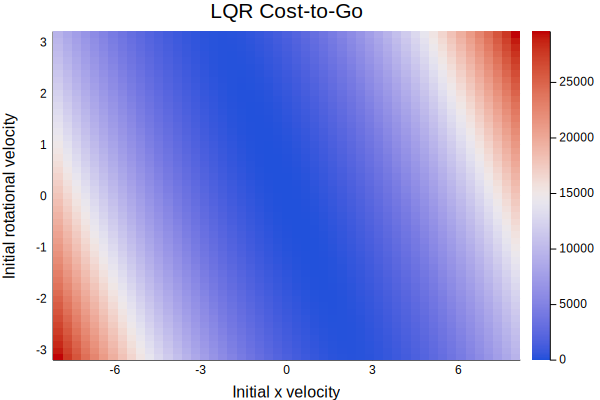

In [456]:
xx = linspace(-8, 8, 51)
yy = linspace(-π, π, 51)
getstate(x, y) = [0, 0, x, y]
plt = heatmap(xx, yy, (x, y) -> (getstate(x, y) - lqrsol.x0)' * lqrsol.S * (getstate(x, y) - lqrsol.x0), color=:coolwarm)
title!(plt, "LQR Cost-to-Go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "lqr_cost_to_go.pdf")
plt

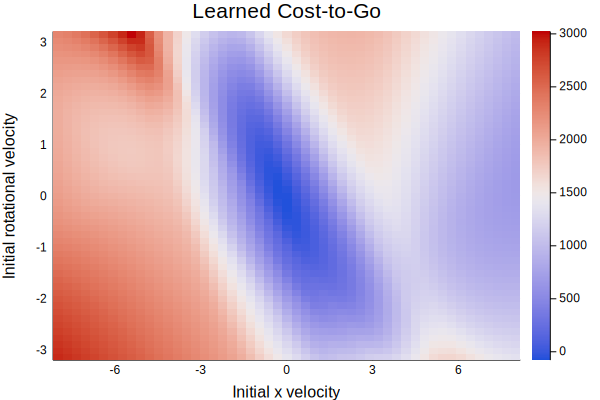

In [457]:
plt = heatmap(xx, yy, (x, y) -> Flux.Tracker.data(interval_net(getstate(x, y)))[], color=:coolwarm)
title!(plt, "Learned Cost-to-Go")
xlabel!(plt, "Initial x velocity")
ylabel!(plt, "Initial rotational velocity")
savefig(plt, "learned_cost_to_go.pdf")
plt

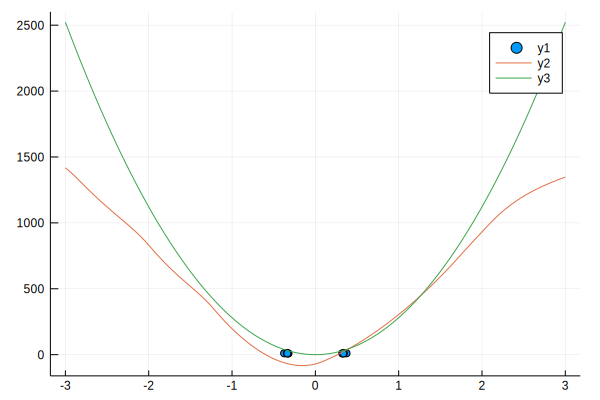

In [458]:
d = [x for x in training if norm(x[1].state[[1,2,4]]) < 0.1]
plt = scatter([s[1].state[3] for s in d], [s[1].mip.objective_value for s in d])
xx = linspace(-3, 3, 101)
yy = [Flux.Tracker.data(interval_net([0, 0, xi, 0]))[1] for xi in xx]
plot!(plt, xx, yy)
yy = [[0, 0, xi, 0]' * lqrsol.S * [0, 0, xi, 0] for xi in xx]
plot!(plt, xx, yy)

In [452]:
state = nominal_state(robot)
set_velocity!(state, [-4.0, 0])
problem = LearningMPC.simulation_problem(state, interval_net_mpc, 0.01, 6.0)
solution = RigidBodySim.solve(problem, Tsit5(), abs_tol=1e-8, dt=1e-6)
setanimation!(mvis, solution)

true

In [207]:
policies = [
            (interval_net_mpc, "MPC + Learned Interval"),
            (lqrsol, "LQR"), 
            (lqr_mpc, "MPC + LQR cost"),
            (policy_net_controller, "Policy Net"), 
#             (upperbound_net_mpc, "MPC + Learned Upper Bound"),
#             (lowerbound_net_mpc, "MPC + Learned Lower Bound"),
]

tables = map(policies) do args
    controller, label = args
    LearningMPC.run_evaluations(
        controller,
        label,
        robot,
        lqrsol,
        [(1, [0])],
        [(1, linspace(-8, 8, 11)), (2, linspace(-π, π, 11))]; 
        mvis=mvis,
        horizon=400)
end
cost_table = vcat(tables...)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:05:43
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,MPC + Learned Interval,"[0.0, 0.0]","[-8.0, -3.14159]",0.01,400,"[2.45057, 4.39498]","[-2.58506e-9, -3.44891e-10]",8193.84,95878.0
2,MPC + Learned Interval,"[0.0, 0.0]","[-6.4, -3.14159]",0.01,400,"[2.44605, 4.38084]","[3.34839e-9, 4.02793e-10]",7818.37,95294.6
3,MPC + Learned Interval,"[0.0, 0.0]","[-4.8, -3.14159]",0.01,400,"[2.39914, 4.25834]","[-5.55492e-9, -3.33061e-10]",5245.24,90240.6
4,MPC + Learned Interval,"[0.0, 0.0]","[-3.2, -3.14159]",0.01,400,"[-0.496512, 0.000840965]","[0.00043896, -0.00252398]",124.537,123.913
5,MPC + Learned Interval,"[0.0, 0.0]","[-1.6, -3.14159]",0.01,400,"[-0.49379, 0.00192422]","[-0.00793857, -0.00192269]",84.3001,123.98
6,MPC + Learned Interval,"[0.0, 0.0]","[0.0, -3.14159]",0.01,400,"[-0.487135, 0.00178792]","[-0.0217949, 0.0044061]",64.9331,123.496
7,MPC + Learned Interval,"[0.0, 0.0]","[1.6, -3.14159]",0.01,400,"[-0.495196, -0.000102707]","[-0.000148309, 0.000348984]",11.3287,123.603
8,MPC + Learned Interval,"[0.0, 0.0]","[3.2, -3.14159]",0.01,400,"[-0.495894, -0.000725024]","[0.00282299, 0.000792437]",20.9725,123.508
9,MPC + Learned Interval,"[0.0, 0.0]","[4.8, -3.14159]",0.01,400,"[-0.506058, 0.00165855]","[0.0189759, -0.0127845]",73.1804,124.788
10,MPC + Learned Interval,"[0.0, 0.0]","[6.4, -3.14159]",0.01,400,"[-0.500496, -0.000865432]","[0.0130422, -0.00323591]",73.4469,123.798


In [377]:
append!(cost_table, 
    LearningMPC.run_evaluations(
        lqrsol,
        "LQR",
        robot,
        lqrsol,
        [(1, [0])],
        [(1, linspace(-8, 8, 11)), (2, linspace(-π, π, 11))]; 
        mvis=mvis,
        horizon=400)
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,MPC + Learned Interval,"[0.0, 0.0]","[-8.0, -3.14159]",0.01,400,"[2.45057, 4.39498]","[-2.58506e-9, -3.44891e-10]",8193.84,95878.0
2,MPC + Learned Interval,"[0.0, 0.0]","[-6.4, -3.14159]",0.01,400,"[2.44605, 4.38084]","[3.34839e-9, 4.02793e-10]",7818.37,95294.6
3,MPC + Learned Interval,"[0.0, 0.0]","[-4.8, -3.14159]",0.01,400,"[2.39914, 4.25834]","[-5.55492e-9, -3.33061e-10]",5245.24,90240.6
4,MPC + Learned Interval,"[0.0, 0.0]","[-3.2, -3.14159]",0.01,400,"[-0.496512, 0.000840965]","[0.00043896, -0.00252398]",124.537,123.913
5,MPC + Learned Interval,"[0.0, 0.0]","[-1.6, -3.14159]",0.01,400,"[-0.49379, 0.00192422]","[-0.00793857, -0.00192269]",84.3001,123.98
6,MPC + Learned Interval,"[0.0, 0.0]","[0.0, -3.14159]",0.01,400,"[-0.487135, 0.00178792]","[-0.0217949, 0.0044061]",64.9331,123.496
7,MPC + Learned Interval,"[0.0, 0.0]","[1.6, -3.14159]",0.01,400,"[-0.495196, -0.000102707]","[-0.000148309, 0.000348984]",11.3287,123.603
8,MPC + Learned Interval,"[0.0, 0.0]","[3.2, -3.14159]",0.01,400,"[-0.495894, -0.000725024]","[0.00282299, 0.000792437]",20.9725,123.508
9,MPC + Learned Interval,"[0.0, 0.0]","[4.8, -3.14159]",0.01,400,"[-0.506058, 0.00165855]","[0.0189759, -0.0127845]",73.1804,124.788
10,MPC + Learned Interval,"[0.0, 0.0]","[6.4, -3.14159]",0.01,400,"[-0.500496, -0.000865432]","[0.0130422, -0.00323591]",73.4469,123.798


In [209]:
@save "cost_table-3.jld2" cost_table

In [321]:
function cost_heatmap(table, label; clim=(0, 10000), feature=:running_cost)
    xs = sort(unique(row[:v0][1] for row in eachrow(table) if row[:controller] == label))              
    ys = sort(unique(row[:v0][2] for row in eachrow(table) if row[:controller] == label))
    zs = zeros(length(ys), length(xs))
    for row in eachrow(table)
        if row[:controller] == label
            x = row[:v0][1]
            y = row[:v0][2]
            ix = findfirst(k -> k == x, xs)
            iy = findfirst(k -> k == y, ys)
            zs[iy, ix] = row[feature][1]
        end
    end

    plt = heatmap(xs, ys, zs, clim=clim, color=:coolwarm, aspect_ratio=8/π)
    xlabel!(plt, "Initial x velocity")
    ylabel!(plt, "Initial rotational velocity")
    title!(plt, label)
    plt
end
                                
                                

cost_heatmap (generic function with 1 method)

In [340]:
function success_heatmap(table, label, q_threshold=π/16, v_threshold=π/32)
    xs = sort(unique(row[:v0][1] for row in eachrow(table) if row[:controller] == label))              
    ys = sort(unique(row[:v0][2] for row in eachrow(table) if row[:controller] == label))
    zs = zeros(Bool, length(ys), length(xs))
    for row in eachrow(table)
        if row[:controller] == label
            x = row[:v0][1]
            y = row[:v0][2]
            ix = findfirst(k -> k == x, xs)
            iy = findfirst(k -> k == y, ys)
            success = (isapprox(row[:qf][2], 0, atol=q_threshold) && 
                isapprox(row[:vf][2], 0, atol=v_threshold))
            zs[iy, ix] = success
        end
    end

    plt = heatmap(xs, ys, zs, colorbar=false, aspect_ratio=8/π)
    xlabel!(plt, "Initial x velocity")
    ylabel!(plt, "Initial rotational velocity")
    title!(plt, label)
    plt
end
                                
   

success_heatmap (generic function with 3 methods)

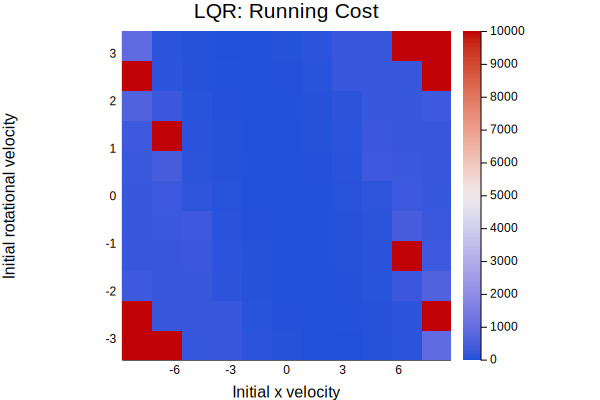

In [378]:
label = "LQR"
plt = cost_heatmap(cost_table, label)
title!(plt, "$label: Running Cost")
savefig(plt, "lqr_running_cost.pdf")
plt

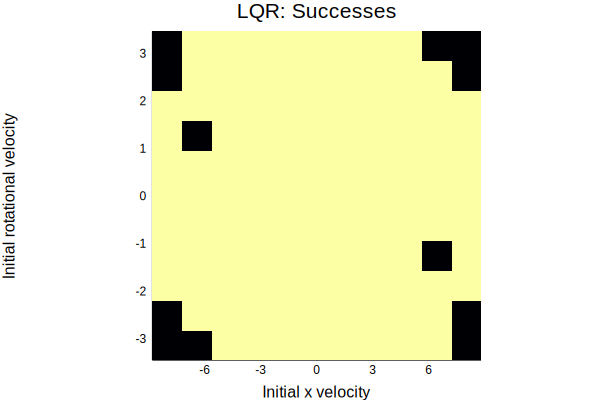

In [379]:
plt = success_heatmap(cost_table, label)
title!(plt, "$label: Successes")
savefig(plt, "lqr_successes.pdf")
plt

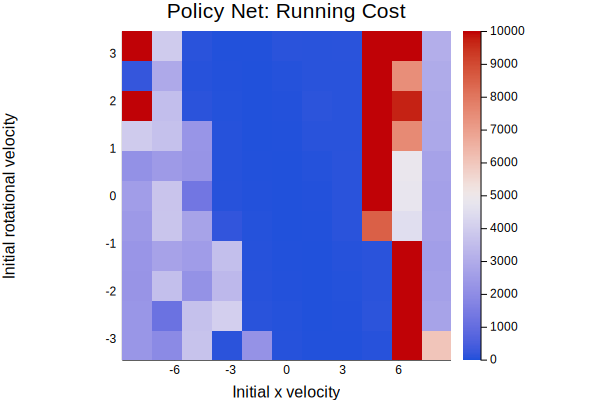

In [357]:
label = "Policy Net"
plt = cost_heatmap(cost_table, label)
title!(plt, "Policy Net: Running Cost")
savefig(plt, "policy_net_running_cost.pdf")
plt

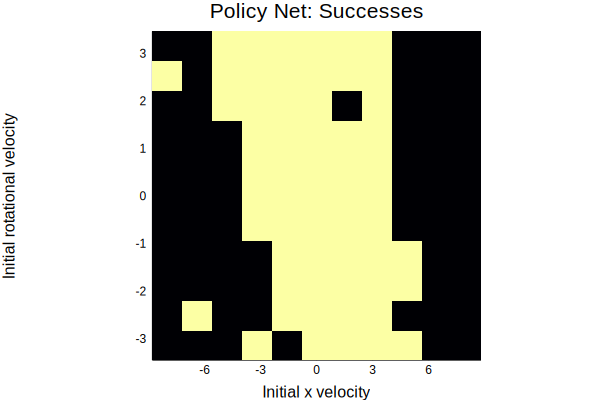

In [358]:
plt = success_heatmap(cost_table, label)
title!(plt, "Policy Net: Successes")
savefig(plt, "policy_net_successes.pdf")
plt

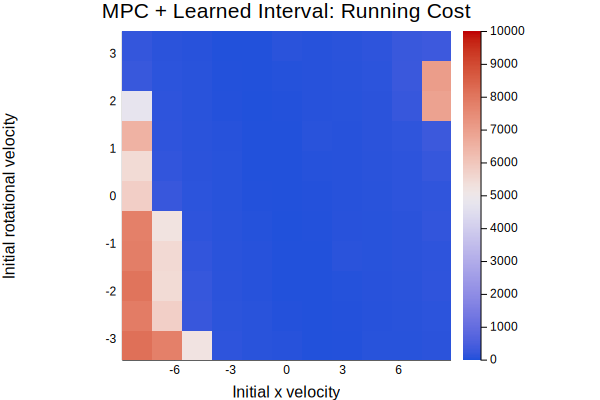

In [359]:
label = "MPC + Learned Interval"
plt = cost_heatmap(cost_table, label)
title!(plt, "MPC + Learned Interval: Running Cost")
savefig(plt, "mpc_interval_running_cost.pdf")
plt

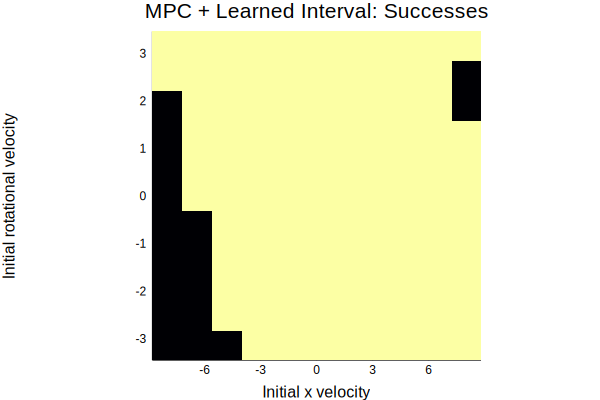

In [360]:
plt = success_heatmap(cost_table, label)
title!(plt, "MPC + Learned Interval: Successes")
savefig(plt, "mpc_interval_successes.pdf")
plt

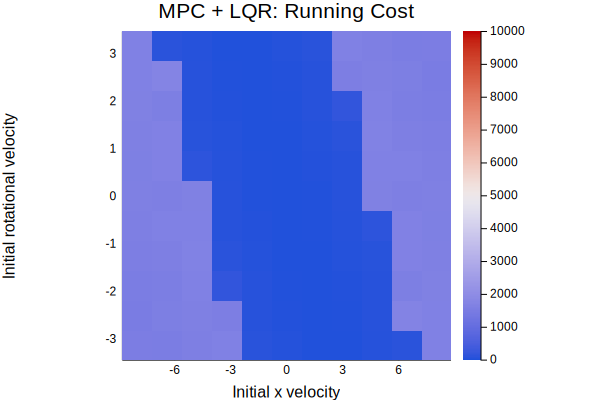

In [361]:
label = "MPC + LQR cost"
plt = cost_heatmap(cost_table, label)
title!(plt, "MPC + LQR: Running Cost")
savefig(plt, "mpc_lqr_running_cost.pdf")
plt

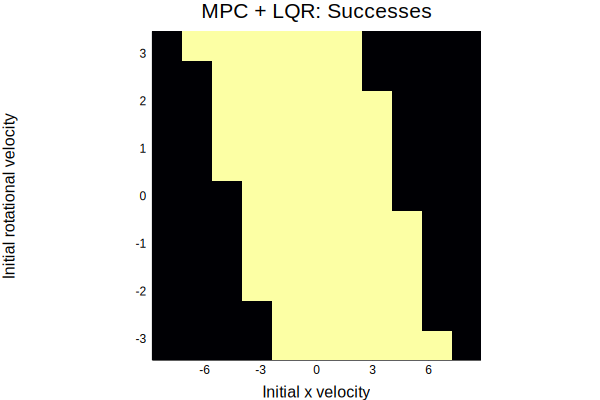

In [362]:
plt = success_heatmap(cost_table, label)
title!(plt, "MPC + LQR: Successes")
savefig(plt, "mpc_lqr_successes.pdf")
plt